In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy as np
from typing import Tuple
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

2023-06-12 08:55:42.256376: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 08:55:42.288841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 08:55:42.491122: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 08:55:42.492428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 08:55:44.590111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Load the data and label
def load_data(filename: str) -> Tuple[np.ndarray, np.ndarray]:
    data = np.load(f'{filename}')
    return data['data'], data['labels']
# Split the data and labels into training and testing sets
train_data, train_labels = load_data('train_data_SYN.npz')
print(train_data.shape)
print(np.unique(train_labels, return_counts=True))
test_data, test_labels = load_data('test_data_SYN.npz')
print(test_data.shape)
print(np.unique(test_labels, return_counts=True))
x_train = train_data
y_train = train_labels
x_test = test_data
y_test = test_labels

(5000, 1024)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([563, 633, 529, 482, 486, 456, 504, 486, 442, 419]))
(5000, 1024)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([483, 539, 539, 484, 490, 526, 483, 506, 471, 479]))


2023-06-12 08:55:56.548680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 08:55:56.550376: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
157/157 [==============================] - 3s 9ms/step - loss: 1.0232 - accuracy: 0.6832 - val_loss: 0.6126 - val_accuracy: 0.8140
Epoch 2/10
157/157 [==============================] - 1s 6ms/step - loss: 0.3784 - accuracy: 0.8906 - val_loss: 0.5070 - val_accuracy: 0.8402
Epoch 3/10
157/157 [==============================] - 1s 6ms/step - loss: 0.2654 - accuracy: 0.9280 - val_loss: 0.4411 - val_accuracy: 0.8642
Epoch 4/10
157/157 [==============================] - 1s 6ms/step - loss: 0.1992 - accuracy: 0.9486 - val_loss: 0.4322 - val_accuracy: 0.8658
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 0.1522 - accuracy: 0.9648 - val_loss: 0.4298 - val_accuracy: 0.8704
Epoch 6/10
157/157 [==============================] - 1s 6ms/step - loss: 0.1189 - accuracy: 0.9804 - val_loss: 0.4404 - val_accuracy: 0.8682
Epoch 7/10
157/157 [==============================] - 1s 5ms/step - loss: 0.0930 - accuracy: 0.9878 - val_loss: 0.4459 - val_accuracy: 0.8694
Epoch 

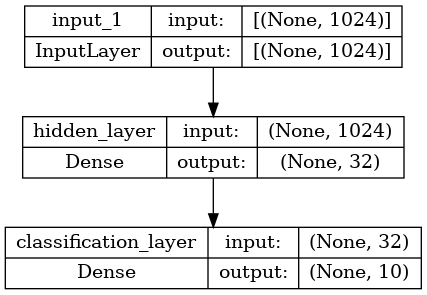

In [3]:
input_tensor = tf.keras.Input(shape=(1024,))

hidden_size = 32
reg_l1_param = 10e-5

hidden_layer_1 = tf.keras.layers.Dense(units=hidden_size, activation=tf.nn.relu, 
                                       name = 'hidden_layer',
                                       activity_regularizer=tf.keras.regularizers.l1(reg_l1_param))(input_tensor)

output_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax, name = 'classification_layer')(hidden_layer_1)

model = tf.keras.Model(inputs=input_tensor, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels))
test_loss, test_acc = model.evaluate(test_data, test_labels)

print('reg_l1_param:', reg_l1_param, ' hidden_size:', hidden_size, ' Test accuracy:', test_acc)

# Plot the model architecture
plot_model(model, to_file='model.png', show_shapes=True)

In [7]:
# input: # of features, x_train with n features, x_test with n features
# return: hidden layer weights, prints accuracy
def train_model(size: int, l1: float) -> float:
    input_tensor = tf.keras.Input(shape=(1024,))
    hidden_size = size
    reg_l1_param = l1
    hidden_layer_1 = tf.keras.layers.Dense(units=hidden_size, activation=tf.nn.relu, 
                                           name = 'hidden_layer',
                                           activity_regularizer=tf.keras.regularizers.l1(reg_l1_param))(input_tensor)
    output_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax, name = 'classification_layer')(hidden_layer_1)
    model = tf.keras.Model(inputs=input_tensor, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, 
                        validation_data=(x_test, y_test))
    test_loss, test_acc = model.evaluate(x_test, y_test)

    return test_acc

In [24]:
h_size = 32
l1 = 0.00001
for i in range(5):
    l1 *= 10
    acc = train_model(h_size, l1)
    print('##### hidden_size:', h_size, ' reg_l1_param:', l1, ' test accuracy:', acc)

Epoch 1/10
157/157 [==============================] - 3s 9ms/step - loss: 0.9843 - accuracy: 0.6832 - val_loss: 0.6791 - val_accuracy: 0.7846
Epoch 2/10
157/157 [==============================] - 1s 7ms/step - loss: 0.3846 - accuracy: 0.8852 - val_loss: 0.4743 - val_accuracy: 0.8508
Epoch 3/10
157/157 [==============================] - 1s 7ms/step - loss: 0.2651 - accuracy: 0.9216 - val_loss: 0.4854 - val_accuracy: 0.8472
Epoch 4/10
157/157 [==============================] - 1s 6ms/step - loss: 0.2033 - accuracy: 0.9460 - val_loss: 0.4570 - val_accuracy: 0.8542
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 0.1602 - accuracy: 0.9640 - val_loss: 0.4388 - val_accuracy: 0.8658
Epoch 6/10
157/157 [==============================] - 1s 6ms/step - loss: 0.1249 - accuracy: 0.9744 - val_loss: 0.4276 - val_accuracy: 0.8682
Epoch 7/10
157/157 [==============================] - 1s 6ms/step - loss: 0.0968 - accuracy: 0.9840 - val_loss: 0.4422 - val_accuracy: 0.8652
Epoch 

In [ ]:
##### hidden_size: 32  reg_l1_param: 10e-06  test accuracy: 0.8677999973297119
##### hidden_size: 32  reg_l1_param: 10e-05  test accuracy: 0.8646000027656555
##### hidden_size: 32  reg_l1_param: 0.001  test accuracy: 0.871399998664856
##### hidden_size: 32  reg_l1_param: 0.01  test accuracy: 0.8712000250816345
##### hidden_size: 32  reg_l1_param: 0.1  test accuracy: 0.8483999967575073
##### hidden_size: 32  reg_l1_param: 1.0  test accuracy: 0.10700000077486038

##### hidden_size: 100  reg_l1_param: 0.001  test accuracy: 0.8835999965667725    #BEST
##### hidden_size: 200  reg_l1_param: 0.001  test accuracy: 0.8903999924659729
##### hidden_size: 300  reg_l1_param: 0.001  test accuracy: 0.8971999883651733
##### hidden_size: 400  reg_l1_param: 0.001  test accuracy: 0.8956000208854675
##### hidden_size: 500  reg_l1_param: 0.001  test accuracy: 0.8953999876976013

##### hidden_size: 100  reg_l1_param: 0.0001  test accuracy: 0.8822000026702881
##### hidden_size: 100  reg_l1_param: 0.01  test accuracy: 0.8808000087738037